In [ ]:
!unzip fashion-mnist.zip

In [2]:
from glob import glob 
import numpy as np
import matplotlib.pyplot as plt


In [15]:
from PIL import Image
import torch
from torch.autograd import Variable

In [9]:
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)


In [10]:
train_files[0]

'./fashion-mnist/train/7/38528.png'

In [11]:
len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [13]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))



N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )


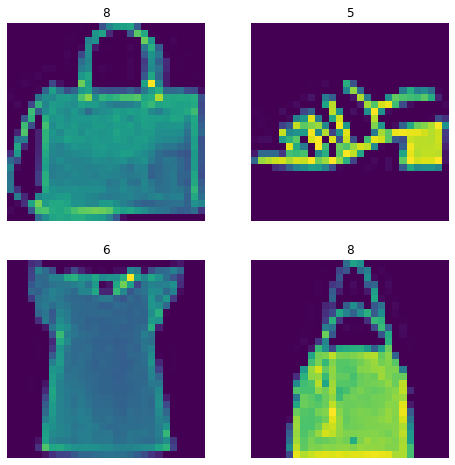

In [14]:
ig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [16]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [17]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Debe ser diferente a la utilizada en clase.

Tener al menos dos capas convolucionales.

Tener capas de Max o Global Average Pooling.

In [18]:

#--- Definimos la CNN

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
  # ( (28-5+2*2)/1 ) + 1 = 28   -> 28*28*16

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 28/2 = 14                 -> 14*14*16

  torch.nn.Dropout(p=0.2),

  torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
  # ( (14-5+2*2)/1 ) + 1 = 14   -> 14*14*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 14/2 = 7                 -> 7*7*32

  torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(7*7*32, 10)
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=10, bias=True)
)